In [28]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
import random
import glob
import os
from sklearn.cluster import KMeans
from PIL import Image as im 

# Set seed for K-means clustering reproducibility
random.seed(10)

In [29]:
def remove_large_background(array,window_size,step_size,max_mean):
    '''
    Scans across an image and removes large pixel blobs i.e. blocks where almost all pixels are filled in.
    Parameters:
    array: input 2d array of pixels
    window_size: size of box used when calculating proportion of filled pixels.  Should be larger than desired cell width.
    step_size: movement distance between one window and the next
    max_mean: mean that pixels in a window must reach for them to be removed.
    '''
    clean_array=np.copy(array)
    for i in range(0,len(array)-window_size,step_size):
        for j in range(0,len(array[i])-window_size,step_size):    
            subset=array[i:i+window_size,j:j+window_size]
            if subset.mean()>max_mean:
                clean_array[max(i-step_size,0):min(i+window_size+step_size,len(array)-1),max(j-window_size,0):min(j+window_size+step_size,len(array[i]))]=0 #replace pixels of region passing max_mean threshold with 0
    return clean_array

def make_custom_grayscale(red_channel,blue_channel):
    '''
    Convert red and blue channels to a single grayscale array by taking the max at each coordinate.
    Parameters:
    red_channel: 2d np array of red pixel values
    blue_channel: 2d np array of blue pixel values
    '''
    custom_gray=[]
    for i,row in enumerate(red_channel):
        custom_gray.append([])
        for j,col in enumerate(row):
            if red_channel[i,j]>blue_channel[i,j]:
                custom_gray[-1].append(red_channel[i,j]*255)
            else:
                custom_gray[-1].append(blue_channel[i,j]*255)
    custom_gray=np.array(custom_gray).astype(np.uint8)
    return custom_gray

In [30]:
# K-means approach as a function
def Kmeans_process_image(image_path):
    # 1. Read image and convert to RGB
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Split into RGB channels for thresholding
    red_channel = image_rgb[:, :, 0]
    blue_channel = image_rgb[:, :, 2]
    
    # 2. Define thresholds for red and blue channels based on percentiles
    #     # try: r-92,b-95
    # red_threshold = np.percentile(red_channel, 85)
    # blue_threshold = np.percentile(blue_channel, 95)
    
    #     # Create binary masks for each color channel
    #         # CHANGED from red/blue_threshold
    # _, red_mask = cv2.threshold(red_channel, red_threshold, 255, cv2.THRESH_BINARY)
    # _, blue_mask = cv2.threshold(blue_channel, blue_threshold, 255, cv2.THRESH_BINARY)
    #     # Combine the red and blue masks
    # combined_mask = cv2.bitwise_or(red_mask, blue_mask)

    #---------------------NEW
    # Normalize red and blue channels
    red_normalized = red_channel / (np.max(red_channel) + 1e-6)
    blue_normalized = blue_channel / (np.max(blue_channel) + 1e-6)
    
    # Define combined mask based on adaptive thresholds
    red_threshold = np.percentile(red_normalized, 95)
    blue_threshold = np.percentile(blue_normalized, 95)
    
    _, red_mask = cv2.threshold((red_normalized * 255).astype(np.uint8), red_threshold * 255, 255, cv2.THRESH_BINARY)
    _, blue_mask = cv2.threshold((blue_normalized * 255).astype(np.uint8), blue_threshold * 255, 255, cv2.THRESH_BINARY)
    
    # Combine the masks
    combined_mask = cv2.bitwise_or(red_mask, blue_mask)
    #---------------------
        # Apply the mask to isolate high-intensity pixels in the image
    thresholded_image = cv2.bitwise_and(image_rgb, image_rgb, mask=combined_mask)

    # 3. Perform K-means clustering
        # Flatten the masked pixels (ignore dark background)
    masked_pixels = thresholded_image[combined_mask > 0]
    pixels = masked_pixels.reshape((-1, 3)).astype(np.float32)
        # Define K-means criteria and number of clusters
    k = 4  # Number of clusters
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        # Perform K-means clustering--cv2
    # _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        # preform K-means clustering--scikit
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(pixels)
        # Convert centers to uint8 for display
    centers = np.uint8(kmeans.cluster_centers_)
        # Reconstruct segmented data using labels
    labels = kmeans.labels_
    segmented_data = centers[labels.flatten()]
        # Create an empty array to store the full-sized segmented image
    segmented_image = np.zeros_like(image_rgb)
        # Fill in only the high-intensity pixels in the original mask
    segmented_image[combined_mask > 0] = segmented_data

    # 4. Subset mask by keeping only the clusters corresponding to red and blue
        # Automate cluster characterization based on RBG values
            # instantiate cluster values
    bg_cluster = -1
    red_cluster = -1
    blue_cluster = -1
    lab_cluster = -1
        # instantiate list of color values outside loop
    max_g_val = -1
    max_r_val = -1
    max_b_val = -1
        # 4.1: Identify labels cluster
            # iterate over centers (RGB values)
    for idx, cntr in enumerate(centers):
        print(idx, cntr)
            # set green value
        g_val = cntr[1]
            # compare to max green value
        if g_val > max_g_val:
                # update max green value
            max_g_val = g_val
                # set max green value to background cluster
            lab_cluster = idx
        # identify red cluster
    for idx, cntr in enumerate(centers):
            # exclude cluster previously identified as bg
        if idx != lab_cluster:
            # set red value
            r_val = cntr[0]
            # compare to max red value
            if r_val > max_r_val:
                max_r_val = r_val
                red_cluster = idx
        # 4.3: Identify BLUE cluster
    for idx, cntr in enumerate(centers):
            # exclude clusters previously identified as bg & red
        if idx != lab_cluster and idx != red_cluster:
            # set red value
            b_val = cntr[2]
            # compare to max red value
            if b_val > max_b_val:
                max_b_val = b_val
                blue_cluster = idx
        # 4.2: Identify bg cluster
    for idx, cntr in enumerate(centers):
            # exclude cluster previously identified as bg
        if idx != lab_cluster and idx != red_cluster and idx != blue_cluster:
            bg_cluster = idx
    print("Background cluster is", bg_cluster)
    print("Labeled cluster is", lab_cluster)
    print("Red cluster is", red_cluster)
    print("Blue cluster is", blue_cluster)
        # Reshape labels to match combined_mask shape
    labels_reshaped = np.zeros(combined_mask.shape, dtype=int)
    labels_reshaped[combined_mask > 0] = labels.flatten()
        # Create a mask that includes only the red and blue clusters
    foreground_mask = np.isin(labels_reshaped, [red_cluster, blue_cluster])
    bg_mask = np.isin(labels_reshaped, [bg_cluster, lab_cluster])
        # Initialize the foreground image with black background
    foreground_final = np.zeros_like(image_rgb)
    bground_final = np.zeros_like(image_rgb)
        # Apply the mask to keep only the red and blue clusters
    foreground_final[foreground_mask] = image_rgb[foreground_mask]
    bground_final[bg_mask] = image_rgb[bg_mask]

    # 5. Perform Canny edge detection on the final foreground
        # foreground_final or custom_gray
    edges = cv2.Canny(foreground_final, 100, 200, apertureSize=3, L2gradient=False)

    # 6. Find contours and filter by area
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Set minimum & maximum cell area threshold
    min_area = 500
    max_area = 20000
    
    # Set aspect ratio thresholds (adjust based on cell shapes in your images)
    min_aspect_ratio = 2.0  # Minimum ratio for pencil-shaped cells
    max_aspect_ratio = 25.0  # Maximum ratio for pencil-shaped cells
    
    cell_contours = []
    # for cnt in contours:
    #     area = cv2.contourArea(cnt)
    #     if min_area < area < max_area:
    #         # Calculate bounding rectangle and aspect ratio
    #         x, y, w, h = cv2.boundingRect(cnt)
    #         aspect_ratio = max(w, h) / min(w, h)  # Ensure the ratio is always >= 1
    #         # print(w,h,aspect_ratio)
    #         # Filter by aspect ratio
    #         if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
    #             cell_contours.append(cnt)
    #---------------------NEW
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            # Get rotated bounding box
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            # Calculate width and height of the rotated rectangle
            width = rect[1][0]
            height = rect[1][1]
            # Ensure width is the smaller dimension
            short_side, long_side = sorted([width, height])
            # Calculate aspect ratio
            aspect_ratio = long_side / short_side
            print(short_side, long_side, aspect_ratio)
            # Filter by aspect ratio
            if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
                cell_contours.append(cnt)

    #---------------------

        # Initialize metrics for counting and blue:red ratio
    total_cells = len(cell_contours)
    cell_ratios = []
        # Create a copy of the original image for cell-labeling
    labeled_image = foreground_final.copy()
        # Count all filtered edges (cells) & calculate blue:red ratio
    print(f"Total cells detected: {total_cells}")

    # 7. Calculate blue:red ratios within each cell
    for i, contour in enumerate(cell_contours):
        # Create a mask for each cell
        cell_mask = np.zeros(foreground_mask.shape, dtype=np.uint8)
        cv2.drawContours(cell_mask, [contour], -1, 255, -1)  # Fill contour to create mask
        # Extract pixels in red and blue channels for this cell
        red_values = red_channel[cell_mask == 255]
        blue_values = blue_channel[cell_mask == 255]
        # Calculate blue:red ratio for this cell
        red_sum = np.sum(red_values)
        blue_sum = np.sum(blue_values)
        blue_red_ratio = blue_sum / red_sum if red_sum > 0 else 0  # Avoid division by zero
        proportion_infected = blue_sum / (blue_sum + red_sum) if (blue_sum + red_sum) > 0 else 0
        cell_ratios.append({
            'Cell Number': i + 1,
            'Red Intensity Sum': red_sum,
            'Blue Intensity Sum': blue_sum,
            'Blue:Red Ratio': blue_red_ratio,
            'Proportion Infected': proportion_infected
        })
            # Label the detected cell on the image
        M = cv2.moments(contour)  # Get moments of the contour to calculate centroid
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])  # Centroid X
            cY = int(M["m01"] / M["m00"])  # Centroid Y
            cv2.putText(
                labeled_image, 
                str(i + 1),  # Label with cell number
                (cX, cY),  # Position at centroid
                cv2.FONT_HERSHEY_SIMPLEX, 
                3,  # Font size
                (255, 255, 255),  # White text
                2  # Thickness
            )

    # add edges to labeled image
    cv2.drawContours(labeled_image, cell_contours, -1, (0, 255, 0), 2)  # Green contours with thickness 2

    # 8. Convert ratios to DataFrame for easy viewing
    cell_ratios_df = pd.DataFrame(cell_ratios)
        # Calculate & report image overall blue:red ratio
    total_red = np.sum(red_channel[foreground_mask])
    total_blue = np.sum(blue_channel[foreground_mask])
    overall_blue_red_ratio = total_blue / total_red if total_red > 0 else 0
        # Display results
    print("\nIndividual Cell Blue:Red Ratios")
    # print(cell_ratios_df)
    print(f"\nTotal Cells: {total_cells}")
    print(f"Overall Blue:Red Ratio in Image: {overall_blue_red_ratio:.2f}")
    # Convert labeled_image (numpy array) to a Pillow image
    labeled_image_pil = im.fromarray(labeled_image)
 
        # Display the final cell edges
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(image_rgb)
    plt.title('Original RGB')
    plt.subplot(1, 4, 2)
    plt.imshow(bground_final, cmap='gray') #edges, bground_final
    plt.title('BG mask') # Canny Edge Detection
    plt.subplot(1, 4, 3)
    plt.imshow(labeled_image)
    plt.title('Foreground with Detected Cells')
    plt.subplot(1, 4, 4)
    plt.imshow(labeled_image_pil)
    plt.title('Returned Image')
    plt.show()
    # print(type(cell_ratios_df))
    # print(type(labeled_image))
    return cell_ratios_df, labeled_image_pil



Processing THN_STARTER_1-20240716.jpg
0 [ 27   0 133]
1 [74  1 81]
2 [231 223 240]
3 [ 28   0 228]
Background cluster is 0
Labeled cluster is 2
Red cluster is 1
Blue cluster is 3
13.84726333618164 228.54296875 16.504558568828397
22.381546020507812 237.30044555664062 10.60250464106485
30.0 32.0 1.0666666666666667
18.602758407592773 176.30364990234375 9.477285359486519
12.75964069366455 270.5638122558594 21.2046576194109
20.509992599487305 48.73662185668945 2.3762379055128346
17.245145797729492 245.75621032714844 14.250747033956934
22.18280029296875 267.624755859375 12.064516306546006
34.540931701660156 370.6429748535156 10.730543636021874
61.04167938232422 89.78707122802734 1.4709141710479692
12.155405044555664 65.24227142333984 5.367346557699571
14.276863098144531 96.08555603027344 6.730158814982336
18.742610931396484 130.45370483398438 6.960273854666441
14.229032516479492 69.85160827636719 4.9090904947660965
14.489720344543457 284.7856140136719 19.654320942151
Total cells detected: 1

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


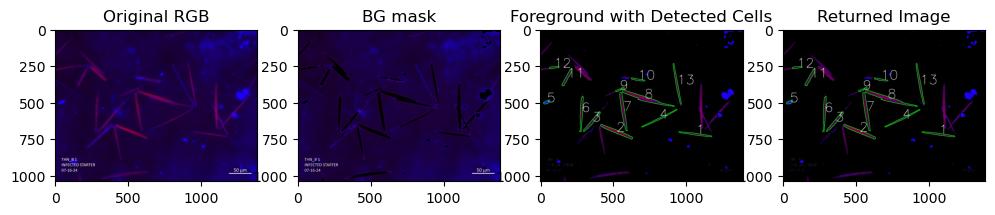

Saved results to ../../figures/Kmeans_new_classification/data/THN_STARTER_1-20240716.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_STARTER_1-20240716_labeled.jpg

Processing THN_A_I_15_1-20240724.jpg
0 [48  0 96]
1 [243 236 246]
2 [ 47   0 204]
3 [139   9  98]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
7.0 156.0 22.285714285714285
14.006736755371094 95.34488677978516 6.80707351362363
17.055330276489258 98.45364379882812 5.772602594189941
17.523582458496094 61.17446517944336 3.4909793887370144
25.738683700561523 65.336669921875 2.5384619773873514
12.579541206359863 279.77618408203125 22.240571376369772
35.0 44.0 1.2571428571428571
22.542131423950195 63.341522216796875 2.8099171735596755
19.33357048034668 201.7861328125 10.437085742523523
Total cells detected: 8

Individual Cell Blue:Red Ratios

Total Cells: 8
Overall Blue:Red Ratio in Image: 2.25


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


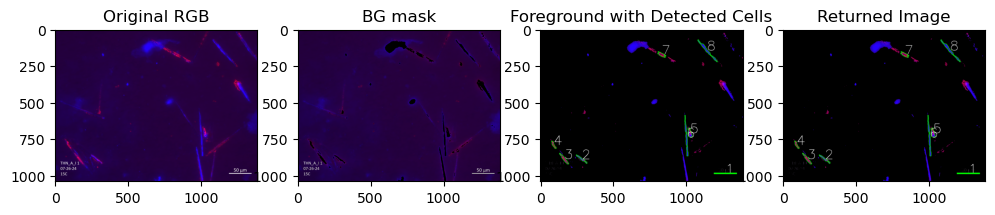

Saved results to ../../figures/Kmeans_new_classification/data/THN_A_I_15_1-20240724.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_A_I_15_1-20240724_labeled.jpg

Processing AS_C_U_15_3-20240717.jpg
0 [56  1 38]
1 [ 13   0 204]
2 [13  0 86]
3 [234 229 237]
Background cluster is 2
Labeled cluster is 3
Red cluster is 0
Blue cluster is 1
5.0 156.0 31.2
89.44403076171875 148.22938537597656 1.6572306068234284
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 2.38


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


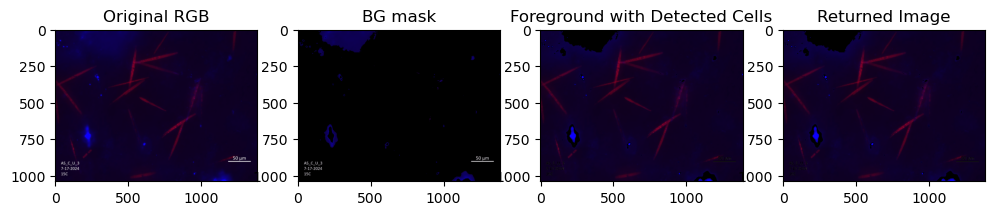

Saved results to ../../figures/Kmeans_new_classification/data/AS_C_U_15_3-20240717.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_C_U_15_3-20240717_labeled.jpg

Processing AS_A_I_22_4-20240718.jpg
0 [ 29   0 101]
1 [ 34   0 217]
2 [230 223 230]
3 [51  0 30]
Background cluster is 0
Labeled cluster is 2
Red cluster is 3
Blue cluster is 1
15.01103401184082 91.7386245727539 6.1114127448109015
27.94193458557129 64.084228515625 2.2934785821421593
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 1.22


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


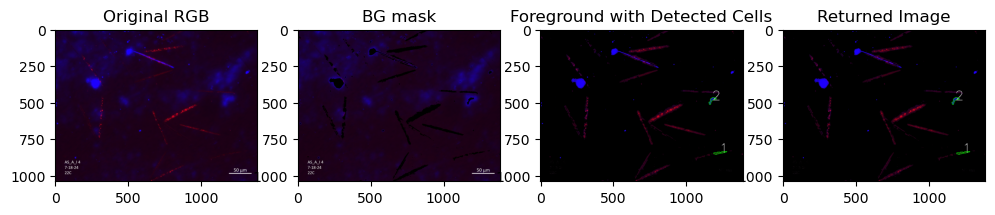

Saved results to ../../figures/Kmeans_new_classification/data/AS_A_I_22_4-20240718.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_A_I_22_4-20240718_labeled.jpg

Processing AS_B_I_22_5-20240720.jpg
0 [44  0 50]
1 [130   3  49]
2 [ 28   0 208]
3 [240 235 242]
Background cluster is 0
Labeled cluster is 3
Red cluster is 1
Blue cluster is 2
18.6317138671875 221.82180786132812 11.905604038498078
33.33387756347656 48.75407791137695 1.462598457636266
70.18327331542969 99.30345916748047 1.414916325164457
10.216236114501953 265.1859130859375 25.95730072345391
16.41692352294922 205.51748657226562 12.518635801949904
19.972545623779297 220.17996215820312 11.024131140101492
Total cells detected: 3

Individual Cell Blue:Red Ratios

Total Cells: 3
Overall Blue:Red Ratio in Image: 0.96


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


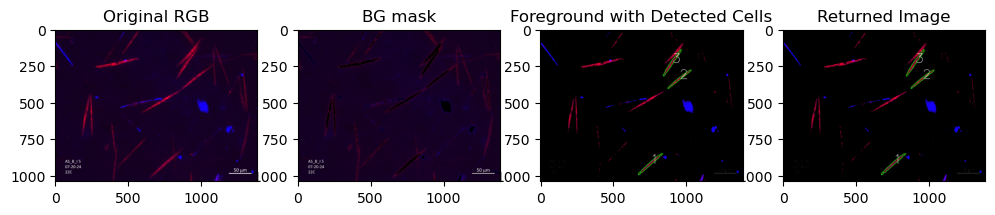

Saved results to ../../figures/Kmeans_new_classification/data/AS_B_I_22_5-20240720.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_B_I_22_5-20240720_labeled.jpg

Processing AS_B_U_15_1-20240726.jpg
0 [ 17   0 205]
1 [133   3  60]
2 [236 232 239]
3 [38  0 71]
Background cluster is 3
Labeled cluster is 2
Red cluster is 1
Blue cluster is 0
12.27303409576416 72.61127471923828 5.916326325883743
17.033733367919922 107.283447265625 6.2982932131410925
17.051271438598633 148.56643676757812 8.7129242709298
36.11982727050781 58.67687225341797 1.6245058929539289
38.0 39.0 1.0263157894736843
27.3521785736084 145.50462341308594 5.319672179731987
45.2205696105957 204.95480346679688 4.532335731984535
26.870058059692383 75.6604232788086 2.81578934852792
19.11237907409668 127.83574676513672 6.688636002327653
13.787528038024902 92.02226257324219 6.674311908519941
21.817663192749023 309.1111755371094 14.167932321910659
23.33452033996582 55.154327392578125 2.363636646008679

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


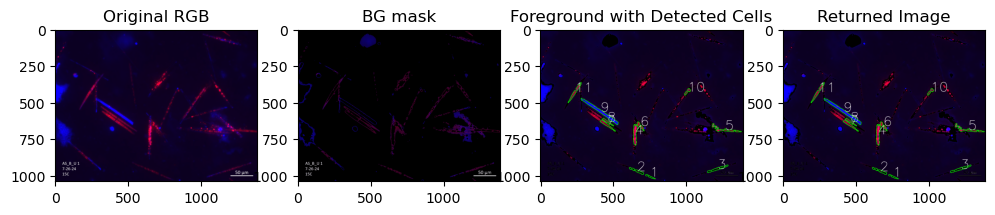

Saved results to ../../figures/Kmeans_new_classification/data/AS_B_U_15_1-20240726.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_B_U_15_1-20240726_labeled.jpg

Processing AS_B_I_22_6-20240717.jpg
0 [38  0 45]
1 [243 237 244]
2 [ 31   0 210]
3 [163  14  49]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
57.784297943115234 73.71401977539062 1.2756756142984922
14.895671844482422 125.86841583251953 8.449999244521694
13.568602561950684 94.44055938720703 6.9602274041130014
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 1.17


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


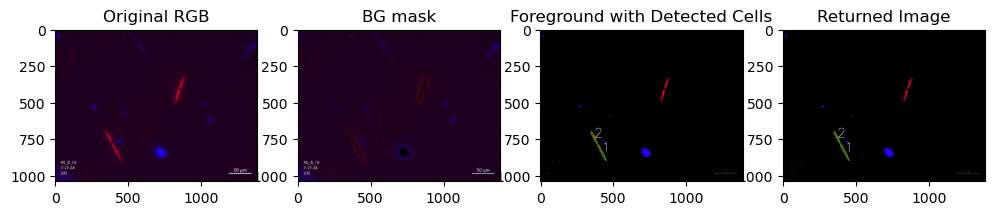

Saved results to ../../figures/Kmeans_new_classification/data/AS_B_I_22_6-20240717.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_B_I_22_6-20240717_labeled.jpg

Processing THN_C_I_22_2-20240720.jpg
0 [15  0 50]
1 [240 236 243]
2 [ 31  16 167]
3 [51  1 40]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
7.0 156.0 22.285714285714285
9.61665153503418 123.60225677490234 12.85294120563796
10.793045043945312 89.57170104980469 8.299020404816401
12.162398338317871 119.80467224121094 9.850415099772222
39.0 40.0 1.0256410256410255
19.772979736328125 268.960205078125 13.60241140509414
33.842350006103516 37.9034309387207 1.119999968438503
15.283746719360352 324.02447509765625 21.200591782066457
Total cells detected: 6

Individual Cell Blue:Red Ratios

Total Cells: 6
Overall Blue:Red Ratio in Image: 1.20


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


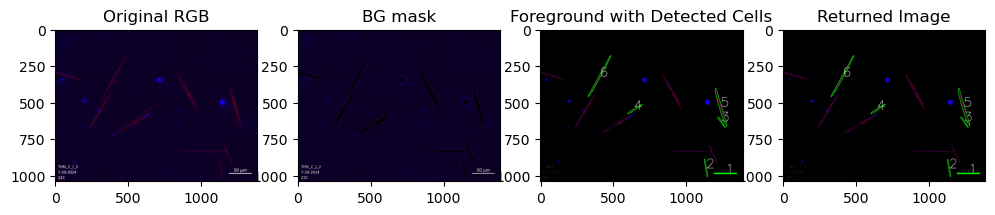

Saved results to ../../figures/Kmeans_new_classification/data/THN_C_I_22_2-20240720.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_C_I_22_2-20240720_labeled.jpg

Processing THN_A_I_22_3-20240724.jpg
0 [32  0 42]
1 [242 237 242]
2 [ 42  10 150]
3 [70  0 29]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
7.0 156.0 22.285714285714285
31.940458297729492 32.847286224365234 1.0283911995934074
17.1796817779541 295.7697448730469 17.216252820968702
17.83409309387207 220.55726623535156 12.367170288638714
15.2255859375 278.6126708984375 18.29897857738439
16.02165412902832 130.078369140625 8.11891007589202
31.0 31.0 1.0
15.914591789245605 135.4923095703125 8.513715674559265
35.58958435058594 265.1858215332031 7.451219967081104
Total cells detected: 7

Individual Cell Blue:Red Ratios

Total Cells: 7
Overall Blue:Red Ratio in Image: 0.83


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


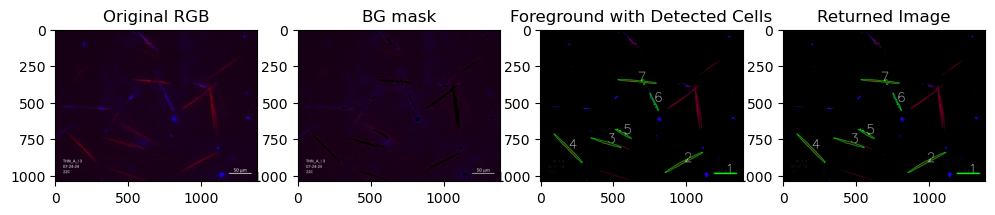

Saved results to ../../figures/Kmeans_new_classification/data/THN_A_I_22_3-20240724.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_A_I_22_3-20240724_labeled.jpg

Processing AS_A_I_22_5-20240718.jpg
0 [ 36   6 135]
1 [42  0 29]
2 [242 236 242]
3 [31  0 79]
Background cluster is 3
Labeled cluster is 2
Red cluster is 1
Blue cluster is 0
44.55401611328125 58.743656158447266 1.318481728091313
23.0 29.0 1.2608695652173914
23.084625244140625 35.73373031616211 1.5479450040122311
44.0 55.0 1.25
27.27650260925293 38.67825698852539 1.4180064630208375
47.37614822387695 57.982749938964844 1.2238806258576822
50.0 64.0 1.28
28.883426666259766 54.65807342529297 1.8923680371048879
22.0 33.0 1.5
29.132801055908203 37.33523941040039 1.2815533713614096
28.174455642700195 35.329872131347656 1.2539682249549116
61.70105743408203 105.16343688964844 1.7044025056134442
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 1.0

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


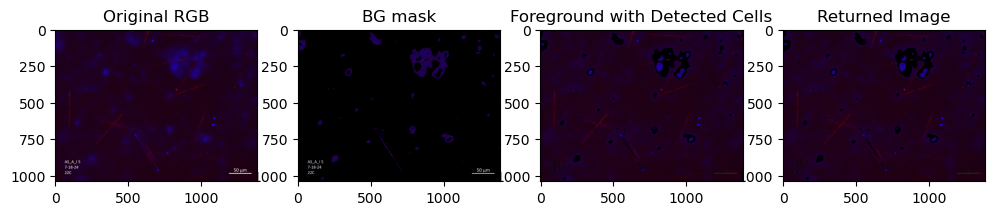

Saved results to ../../figures/Kmeans_new_classification/data/AS_A_I_22_5-20240718.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_A_I_22_5-20240718_labeled.jpg

Processing THN_A_I_22_1-20240717.jpg
0 [42  0 67]
1 [242 235 240]
2 [86  0 29]
3 [145   6  41]
Background cluster is 2
Labeled cluster is 1
Red cluster is 3
Blue cluster is 0
11.31370735168457 120.9152603149414 10.687501148501738
9.371679306030273 123.32347869873047 13.159165467748892
17.647058486938477 126.22179412841797 7.152568470368101
12.21150016784668 148.7702178955078 12.182796204452027
16.77145004272461 115.12416076660156 6.864293813196074
24.934791564941406 49.774776458740234 1.9961978157749722
25.473451614379883 34.00837326049805 1.3350516363200722
Total cells detected: 5

Individual Cell Blue:Red Ratios

Total Cells: 5
Overall Blue:Red Ratio in Image: 0.65


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


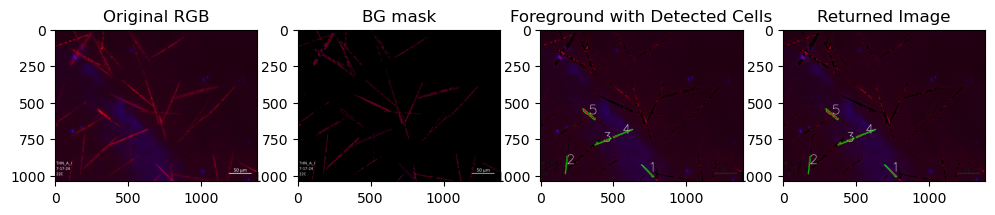

Saved results to ../../figures/Kmeans_new_classification/data/THN_A_I_22_1-20240717.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_A_I_22_1-20240717_labeled.jpg

Processing AS_Starter_3-20240711.jpg
0 [33  0 26]
1 [  3   0 213]
2 [ 4  0 99]
3 [235 234 239]
Background cluster is 2
Labeled cluster is 3
Red cluster is 0
Blue cluster is 1
24.041629791259766 30.40559196472168 1.2647059383542918
21.0 29.0 1.380952380952381
32.0 35.0 1.09375
27.0 30.0 1.1111111111111112
29.698482513427734 48.08325958251953 1.619047692446218
50.82514953613281 86.39620208740234 1.6998710850025385
28.79738426208496 111.8491439819336 3.8840035943540796
30.0 35.0 1.1666666666666667
50.05623245239258 68.63259887695312 1.3711099600280172
31.640329360961914 35.21128463745117 1.112860875617026
27.66860580444336 28.597082138061523 1.033557033562893
60.292755126953125 97.74961853027344 1.6212498222124816
49.64316177368164 111.56916046142578 2.247422534649561
24.748737335205078 26.87005

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


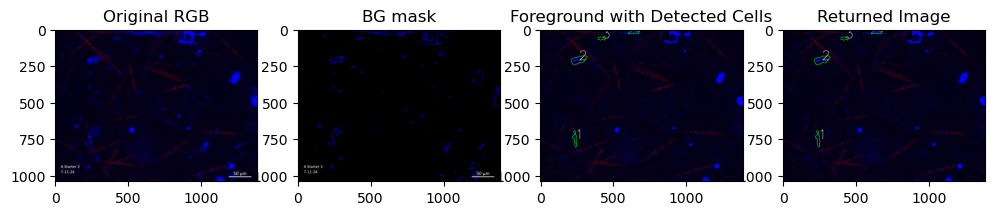

Saved results to ../../figures/Kmeans_new_classification/data/AS_Starter_3-20240711.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_Starter_3-20240711_labeled.jpg

Processing AS_STARTER_2-20240716.jpg
0 [46  0 53]
1 [236 230 240]
2 [ 29   1 210]
3 [26  1 85]
Background cluster is 3
Labeled cluster is 1
Red cluster is 0
Blue cluster is 2
12.0 157.0 13.083333333333334
22.79834747314453 37.350486755371094 1.638297986262748
21.29088592529297 51.62009811401367 2.4245162129533773
25.599586486816406 39.269893646240234 1.5340049991223075
36.0 40.0 1.1111111111111112
28.0 43.0 1.5357142857142858
43.11040496826172 43.82062911987305 1.016474541404429
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 2.19


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


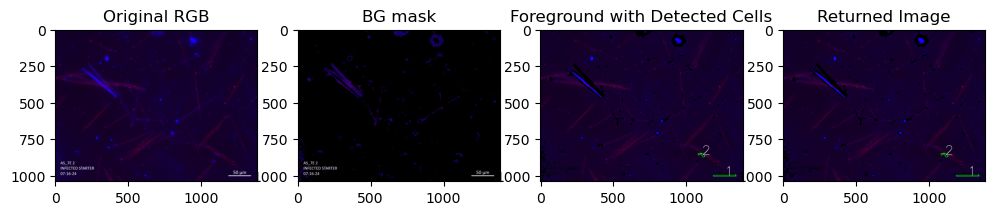

Saved results to ../../figures/Kmeans_new_classification/data/AS_STARTER_2-20240716.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_STARTER_2-20240716_labeled.jpg

Processing AS_STARTER_5-20240716.jpg
0 [ 21   1 208]
1 [19  0 96]
2 [230 225 238]
3 [52  1 62]
Background cluster is 1
Labeled cluster is 2
Red cluster is 3
Blue cluster is 0
7.0 156.0 22.285714285714285
25.298219680786133 44.588111877441406 1.762499987748381
38.91361999511719 61.33051681518555 1.576068143310265
39.04823303222656 46.324302673339844 1.1863354389200744
45.65394592285156 58.41931915283203 1.279611607976933
47.856178283691406 121.00119018554688 2.528434039764978
46.0629997253418 73.79024505615234 1.601941807874841
27.06188201904297 65.15220642089844 2.407526807450124
25.951313018798828 38.80569839477539 1.4953269750422646
28.872045516967773 42.23785400390625 1.4629325095474632
19.15372657775879 51.76335144042969 2.7025211637163618
20.421335220336914 92.46141052246094 4.5276868297

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


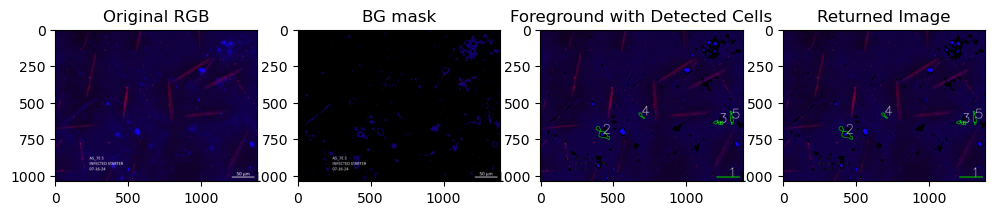

Saved results to ../../figures/Kmeans_new_classification/data/AS_STARTER_5-20240716.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_STARTER_5-20240716_labeled.jpg

Processing AS_Starter_1-20240711.jpg
0 [  4   0 193]
1 [40  0 29]
2 [  3   0 247]
3 [236 236 244]
Background cluster is 0
Labeled cluster is 3
Red cluster is 1
Blue cluster is 2
23.706497192382812 60.26759719848633 2.5422396530960736
15.237712860107422 55.95354080200195 3.672043259752533
45.14971160888672 50.46335983276367 1.1176895274527308
16.042469024658203 68.0281982421875 4.2405067535193135
21.269798278808594 34.00764465332031 1.5988701071604716
28.0 29.0 1.0357142857142858
72.94717407226562 175.40609741210938 2.4045632972477056
67.90489959716797 69.6311264038086 1.0254212408365393
11.49601936340332 66.26651763916016 5.764301150197645
25.103736877441406 49.834869384765625 1.985157414135741
10.0 74.0 7.4
59.28045654296875 64.6876449584961 1.091213677000075
34.230403900146484 62.7777633666

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


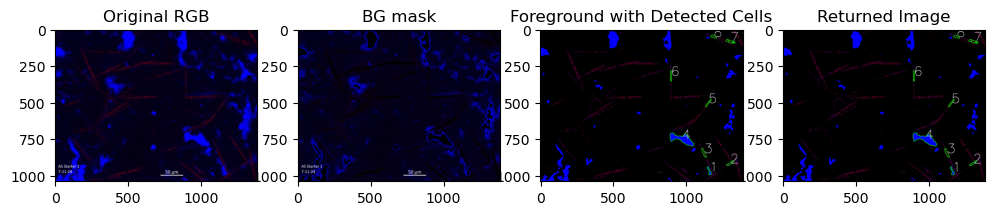

Saved results to ../../figures/Kmeans_new_classification/data/AS_Starter_1-20240711.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_Starter_1-20240711_labeled.jpg

Processing THN_C_I_15_3-20240724.jpg
0 [38  0 53]
1 [ 30   0 193]
2 [107   3  49]
3 [239 235 241]
Background cluster is 0
Labeled cluster is 3
Red cluster is 2
Blue cluster is 1
31.0 38.0 1.2258064516129032
18.722063064575195 219.99411010742188 11.750527137347486
15.453953742980957 101.31360626220703 6.555837292331921
17.21035385131836 182.08213806152344 10.579802114154408
Total cells detected: 3

Individual Cell Blue:Red Ratios

Total Cells: 3
Overall Blue:Red Ratio in Image: 1.10


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


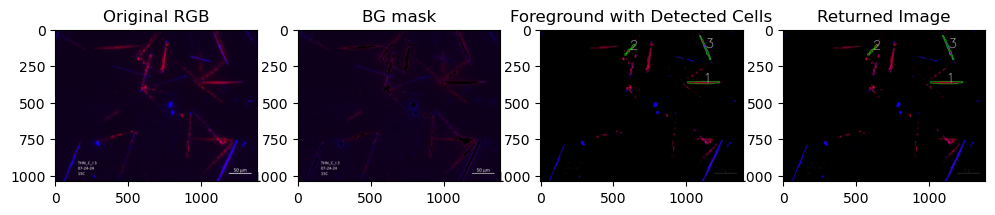

Saved results to ../../figures/Kmeans_new_classification/data/THN_C_I_15_3-20240724.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_C_I_15_3-20240724_labeled.jpg

Processing AS_A_I_15_4-20240720.jpg
0 [ 43   1 172]
1 [ 28   0 242]
2 [240 235 243]
3 [52  0 56]
Background cluster is 0
Labeled cluster is 2
Red cluster is 3
Blue cluster is 1
12.604608535766602 119.24565887451172 9.460480945214798
8.813762664794922 100.08849334716797 11.355932438135016
23.0 29.0 1.2608695652173914
23.832115173339844 268.2752990722656 11.256881612101969
102.06484985351562 131.4639434814453 1.288043275134618
79.5632095336914 92.03721618652344 1.1567810892237806
Total cells detected: 3

Individual Cell Blue:Red Ratios

Total Cells: 3
Overall Blue:Red Ratio in Image: 2.92


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


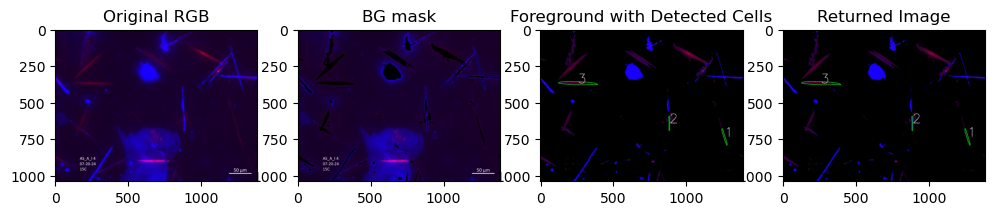

Saved results to ../../figures/Kmeans_new_classification/data/AS_A_I_15_4-20240720.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_A_I_15_4-20240720_labeled.jpg

Processing THN_A_I_15_1-20240717.jpg
0 [80  2 56]
1 [  7   0 218]
2 [24  0 66]
3 [236 234 243]
Background cluster is 2
Labeled cluster is 3
Red cluster is 0
Blue cluster is 1
33.22737503051758 34.1975212097168 1.0291971959358268
27.0 36.0 1.3333333333333333
35.28657150268555 45.24266815185547 1.2821497307669065
19.402847290039062 317.2366027832031 16.350002555865316
53.0 54.0 1.0188679245283019
19.002561569213867 266.4121398925781 14.019801431623492
10.959813117980957 260.2742004394531 23.74805096014278
9.850149154663086 228.13418579101562 23.16048033475882
19.0 36.0 1.894736842105263
8.0 122.0 15.25
15.0518798828125 113.43221282958984 7.536082782531122
14.142135620117188 55.86143493652344 3.949999946052034
Total cells detected: 7

Individual Cell Blue:Red Ratios

Total Cells: 7
Overall Blue:Re

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


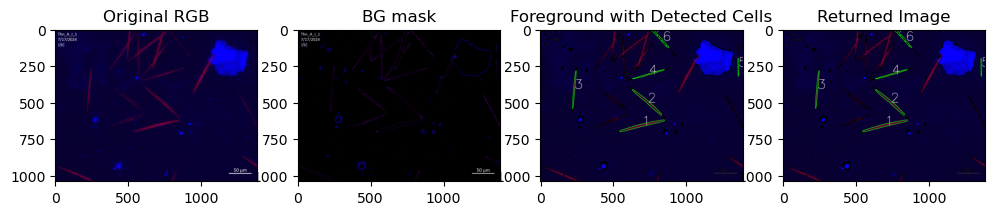

Saved results to ../../figures/Kmeans_new_classification/data/THN_A_I_15_1-20240717.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_A_I_15_1-20240717_labeled.jpg

Processing AS_C_I_15_2-20240726.jpg
0 [ 19   1 133]
1 [48  0 53]
2 [239 235 242]
3 [ 22   0 222]
Background cluster is 0
Labeled cluster is 2
Red cluster is 1
Blue cluster is 3
40.037139892578125 54.308753967285156 1.3564593802903646
28.621667861938477 40.24921798706055 1.4062499146174692
25.0 28.0 1.12
Total cells detected: 0

Individual Cell Blue:Red Ratios

Total Cells: 0
Overall Blue:Red Ratio in Image: 1.90


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


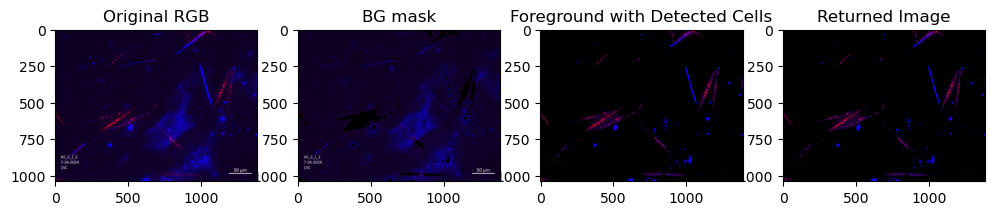

Saved results to ../../figures/Kmeans_new_classification/data/AS_C_I_15_2-20240726.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_C_I_15_2-20240726_labeled.jpg

Processing THN_STARTER_4-20240716.jpg
0 [ 34   0 215]
1 [100   2  85]
2 [239 234 242]
3 [ 35   0 120]
Background cluster is 3
Labeled cluster is 2
Red cluster is 1
Blue cluster is 0
28.635517120361328 113.09754180908203 3.949554720234609
29.99500846862793 36.12225341796875 1.2042754865613512
36.26741409301758 53.363162994384766 1.471380420382896
24.0 26.0 1.0833333333333333
19.197134017944336 74.9976577758789 3.9067111635401184
28.452350616455078 31.048181533813477 1.0912343219845297
29.698484420776367 31.11269760131836 1.0476190353859485
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 2.04


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


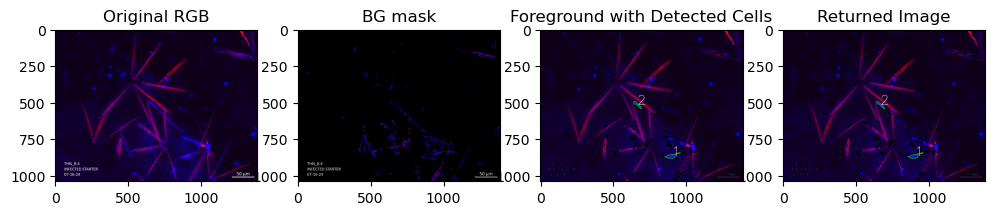

Saved results to ../../figures/Kmeans_new_classification/data/THN_STARTER_4-20240716.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_STARTER_4-20240716_labeled.jpg

Processing AS_B_I_15_4-20240724.jpg
0 [54  0 47]
1 [ 26   0 103]
2 [ 49   0 235]
3 [239 235 243]
Background cluster is 1
Labeled cluster is 3
Red cluster is 0
Blue cluster is 2
5.9871392250061035 157.0222930908203 26.2265979109013
11.741022109985352 91.38453674316406 7.783354454757779
23.05168342590332 34.223968505859375 1.4846624375988822
15.690963745117188 128.0198516845703 8.158826555469439
35.721927642822266 39.0079231262207 1.091988190454182
23.65174102783203 309.15679931640625 13.071206849111363
32.465641021728516 51.58092498779297 1.588785046728972
42.0 49.0 1.1666666666666667
Total cells detected: 3

Individual Cell Blue:Red Ratios

Total Cells: 3
Overall Blue:Red Ratio in Image: 2.27


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


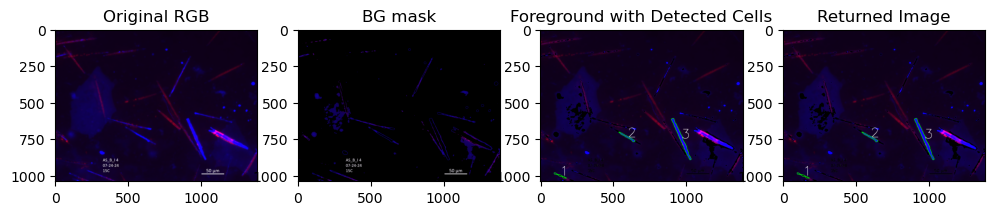

Saved results to ../../figures/Kmeans_new_classification/data/AS_B_I_15_4-20240724.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_B_I_15_4-20240724_labeled.jpg

Processing THN_Starter_5-20240711.jpg
0 [ 6  0 75]
1 [230 229 234]
2 [  4   0 212]
3 [30  0 29]
Background cluster is 0
Labeled cluster is 1
Red cluster is 3
Blue cluster is 2
26.593957901000977 75.44877624511719 2.837064589106436
10.606599807739258 75.66040802001953 7.133332961691722
Total cells detected: 2

Individual Cell Blue:Red Ratios

Total Cells: 2
Overall Blue:Red Ratio in Image: 2.33


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


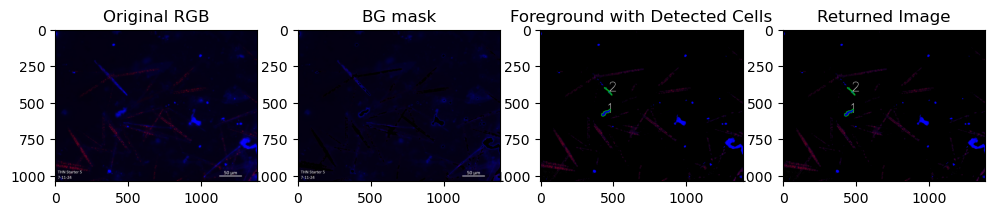

Saved results to ../../figures/Kmeans_new_classification/data/THN_Starter_5-20240711.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_Starter_5-20240711_labeled.jpg

Processing THN_Starter_2-20240711.jpg
0 [14  0 30]
1 [223 222 227]
2 [ 4  0 75]
3 [  3   0 171]
Background cluster is 2
Labeled cluster is 1
Red cluster is 0
Blue cluster is 3
8.178887367248535 109.53866577148438 13.392856613983957
44.044647216796875 63.06330871582031 1.431804151033601
24.0 31.0 1.2916666666666667
115.56098175048828 120.55013275146484 1.043173317891577
23.718191146850586 31.995079040527344 1.3489679226561002
66.12319946289062 179.26304626464844 2.7110461641417345
29.068883895874023 35.329872131347656 1.215384541694162
53.0 71.0 1.3396226415094339
47.0 52.0 1.1063829787234043
37.04860305786133 292.9913024902344 7.908295544440634
37.52949523925781 47.683921813964844 1.2705718931195475
34.0 38.0 1.1176470588235294
Total cells detected: 3

Individual Cell Blue:Red Ratios

Total

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


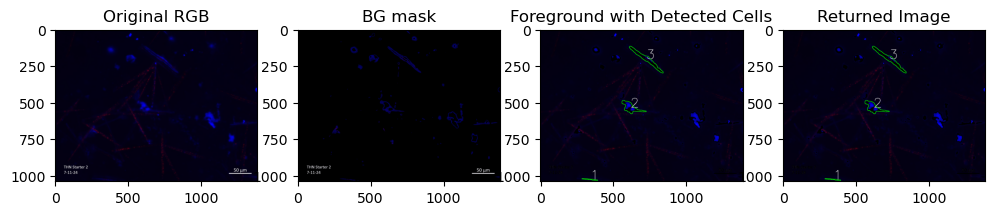

Saved results to ../../figures/Kmeans_new_classification/data/THN_Starter_2-20240711.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_Starter_2-20240711_labeled.jpg

Processing AS_C_I_15_3-20240724.jpg
0 [ 30   0 123]
1 [82  1 59]
2 [241 236 245]
3 [ 42   0 231]
Background cluster is 0
Labeled cluster is 2
Red cluster is 1
Blue cluster is 3
7.0 157.0 22.428571428571427
24.60131072998047 248.8240203857422 10.114258671693943
43.047447204589844 145.0271759033203 3.3690075793357868
17.326427459716797 173.1448974609375 9.993110112485219
27.71831703186035 72.55351257324219 2.6175295018758455
26.969440460205078 176.0386199951172 6.527336755646527
24.446308135986328 132.55331420898438 5.4222221806105155
25.81232452392578 117.94426727294922 4.569300496885708
15.163068771362305 95.42536163330078 6.293275000739011
9.68249225616455 280.0712585449219 28.925533957087232
26.127592086791992 43.99925231933594 1.6840148213113912
Total cells detected: 9

Individual Cell B

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


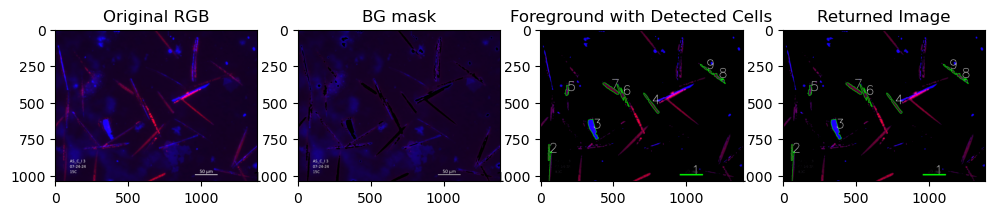

Saved results to ../../figures/Kmeans_new_classification/data/AS_C_I_15_3-20240724.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/AS_C_I_15_3-20240724_labeled.jpg

Processing THN_B_I_15_5-20240726.jpg
0 [ 44   0 206]
1 [171   2  91]
2 [55  0 82]
3 [242 237 244]
Background cluster is 2
Labeled cluster is 3
Red cluster is 1
Blue cluster is 0
5.0 156.0 31.2
28.173791885375977 158.09588623046875 5.611452191940509
24.298147201538086 52.84353256225586 2.174796791045485
29.573028564453125 238.75392150878906 8.0733672910245
33.42814254760742 41.18653106689453 1.2320915231301839
24.732309341430664 93.67118072509766 3.7874013070094956
18.616256713867188 230.85699462890625 12.400827845102805
17.33245086669922 78.91517639160156 4.5530304397528125
85.76847076416016 130.7452850341797 1.52439799694801
11.504603385925293 154.30172729492188 13.412172685908866
21.341999053955078 213.4456024169922 10.00120006928014
32.0 32.0 1.0
255.6396026611328 328.5718078613281 1.2852930

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


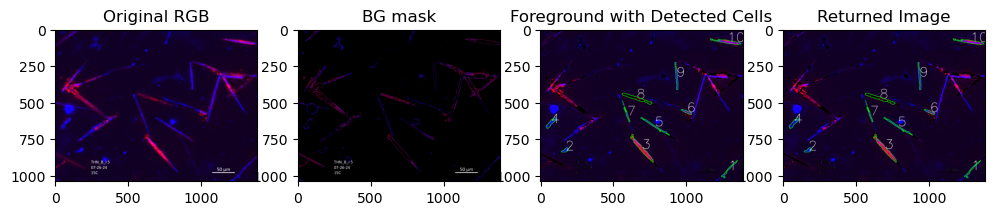

Saved results to ../../figures/Kmeans_new_classification/data/THN_B_I_15_5-20240726.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_B_I_15_5-20240726_labeled.jpg

Processing THN_C_I_15_4-20240720.jpg
0 [141   1  47]
1 [35  0 82]
2 [240 234 243]
3 [ 38   0 220]
Background cluster is 1
Labeled cluster is 2
Red cluster is 0
Blue cluster is 3
46.324302673339844 49.96233367919922 1.0785339615690126
16.345335006713867 208.31871032714844 12.744841891682322
21.610536575317383 57.795623779296875 2.674418729857385
53.80979919433594 92.30878448486328 1.7154642066491819
36.76955032348633 45.25482940673828 1.2307691828864176
26.600000381469727 27.0 1.0150375794283417
12.123605728149414 148.05198669433594 12.21187739144129
63.52937698364258 71.7922592163086 1.1300639582030456
28.0 30.0 1.0714285714285714
26.345252990722656 39.87778854370117 1.5136612488687782
20.540462493896484 100.2107162475586 4.878698144081994
Total cells detected: 4

Individual Cell Blue:Red Rat

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


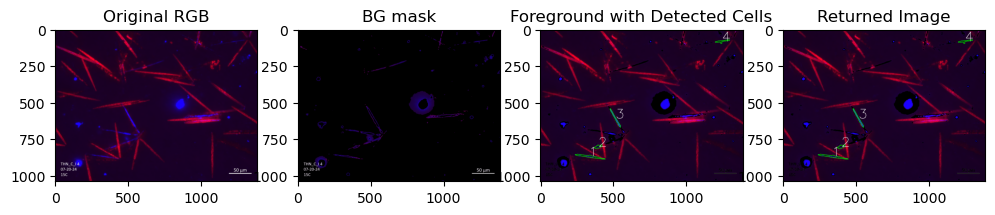

Saved results to ../../figures/Kmeans_new_classification/data/THN_C_I_15_4-20240720.csv
Saved labeled image to ../../figures/Kmeans_new_classification/classified/THN_C_I_15_4-20240720_labeled.jpg


In [31]:
# Process all images in a folder
image_folder = "../../images/raw/"
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))
# csv_folder = "../../figures/Kmeans_classification/data/" # og Kmeans
# jpg_folder = "../../figures/Kmeans_classification/classified/" # og Kmeans
csv_folder = "../../figures/Kmeans_new_classification/data/" # new Kmeans
jpg_folder = "../../figures/Kmeans_new_classification/classified/" # new Kmeans

for image_path in image_paths:
    print("")
    print(f"Processing {os.path.basename(image_path)}")
    df, image_output = Kmeans_process_image(image_path)
    # Generate basename
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    # Generate .csv output filename based on the input image name
    csv_output_path = os.path.join(csv_folder, f"{base_filename}.csv")
    image_output_path = os.path.join(jpg_folder, f"{base_filename}_labeled.jpg")

    # Save the dataframe to a CSV file
    df.to_csv(csv_output_path, index=False)
    # Save the image to a JPG file
    print(f"Saved results to {csv_output_path}")
    # Save the labeled image to a JPG file
    # cv2.imwrite(image_output_path, cv2.cvtColor(image_output, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving--OLD
    image_output.save(image_output_path)  # Convert back to BGR for saving--NEW
    print(f"Saved labeled image to {image_output_path}")


0 [ 43   1 172]
1 [ 28   0 242]
2 [240 235 243]
3 [52  0 56]
Background cluster is 0
Labeled cluster is 2
Red cluster is 3
Blue cluster is 1
12.604608535766602 119.24565887451172 9.460480945214798
8.813762664794922 100.08849334716797 11.355932438135016
23.0 29.0 1.2608695652173914
23.832115173339844 268.2752990722656 11.256881612101969
102.06484985351562 131.4639434814453 1.288043275134618
79.5632095336914 92.03721618652344 1.1567810892237806
Total cells detected: 3

Individual Cell Blue:Red Ratios

Total Cells: 3
Overall Blue:Red Ratio in Image: 2.92


/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_67961/1342544095.py:159: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


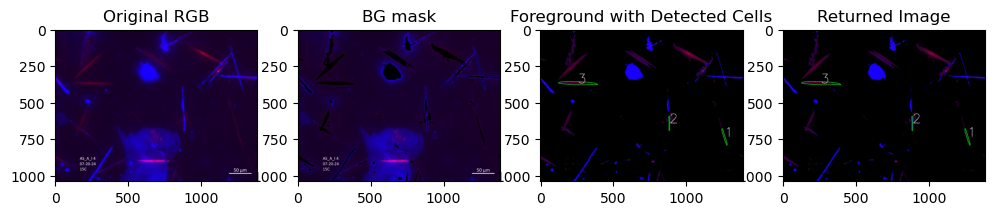

(   Cell Number  Red Intensity Sum  Blue Intensity Sum  Blue:Red Ratio  \
 0            1              50498               47891        0.948374   
 1            2              23768              167014        7.026843   
 2            3             273786              220206        0.804300   
 
    Proportion Infected  
 0             0.486752  
 1             0.875418  
 2             0.445768  ,
 <PIL.Image.Image image mode=RGB size=1388x1040>)

In [27]:
img_path = "../../images/raw/AS_A_I_15_4-20240720.jpg"
Kmeans_process_image(img_path)

# # Convert labeled_image (numpy array) to a Pillow image and save as JPEG
# labeled_image_pil = im.fromarray(labeled_image)
# labeled_image_pil.save("labeled_output.jpg")

0 [ 51   0 150]
1 [57  0 69]
2 [243 234 244]
3 [120   2  72]
Background cluster is 1
Labeled cluster is 2
Red cluster is 3
Blue cluster is 0
Total cells detected: 9

Individual Cell Blue:Red Ratios

Total Cells: 9
Overall Blue:Red Ratio in Image: 1.67


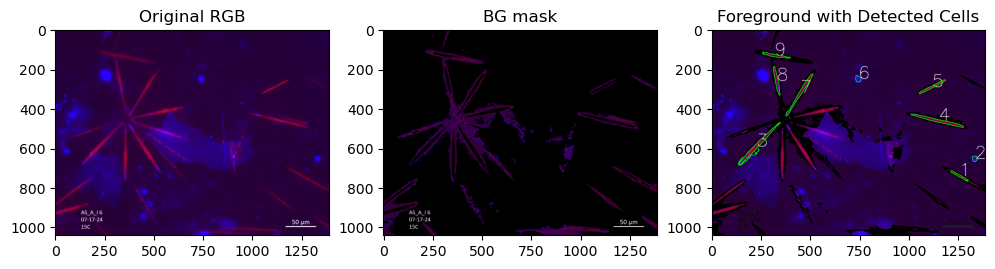

(   Cell Number  Red Intensity Sum  Blue Intensity Sum  Blue:Red Ratio  \
 0            1              95017               51386        0.540808   
 1            2              23231              146917        6.324179   
 2            3             524087              406832        0.776268   
 3            4             417040              246090        0.590087   
 4            5             196079               87974        0.448666   
 5            6              29244              178980        6.120230   
 6            7             334487              234140        0.699997   
 7            8             208639              179183        0.858818   
 8            9             138846               87218        0.628164   
 
    Proportion Infected  
 0             0.350990  
 1             0.863466  
 2             0.437022  
 3             0.371104  
 4             0.309710  
 5             0.859555  
 6             0.411764  
 7             0.462024  
 8             0.385811 

In [60]:
# set image path
# image_path = "../images/manual_classification/raw/AS_A_I_15_4-20240720.jpg"  # WD path
# image_path = "../images/raw/AS_A_I_15_4-20240720.jpg"  # WD path
image_path = "../images/GoodEarlySilica_AS_A_I_15_6_20240717.jpg"  # WD path

# call K-means function
# for image_path in image_paths:
Kmeans_process_image(image_path)

In [14]:
# check blue"red ratios for infection populations
# cell_ratios_df['Blue:Red Ratio'].hist()